In [1]:
import matplotlib.pyplot as plt
import os

import torch
import numpy as np
import albumentations
from PIL import Image

In [2]:
from glob import glob
import random

def plot_augs(folder, tfms, rows, cols, width, height, basewidth=224):
    '''
        Picks a random image from the given folder
        and applies a given albumentations transform
    '''
    folder = glob(os.path.join(folder, '*'))
    img = random.choice(folder)
    
    img = Image.open(img)
    img = np.array(img)

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(width,height))

    for i, ax in enumerate(fig.axes):
        ax.axis("off")
        if i == 0:
            # Original Image
            ax.set_title('Original image')
            ax.imshow(img)
        else:
            aug = tfms(image=img)
            image = aug['image']
            ax.set_title(f'Aug {i}')
            ax.imshow(image)

In [11]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

tfms = albumentations.Compose(
        [
            albumentations.Resize(224, 224),
#             albumentations.RGBShift(p=0.2),
#             albumentations.ChannelDropout(p=0.3),
#             albumentations.ChannelShuffle(p=0.3),
            albumentations.Cutout(num_holes=4, max_h_size=30, max_w_size=30, fill_value=255, always_apply=False, p=0.5),
        ]
)

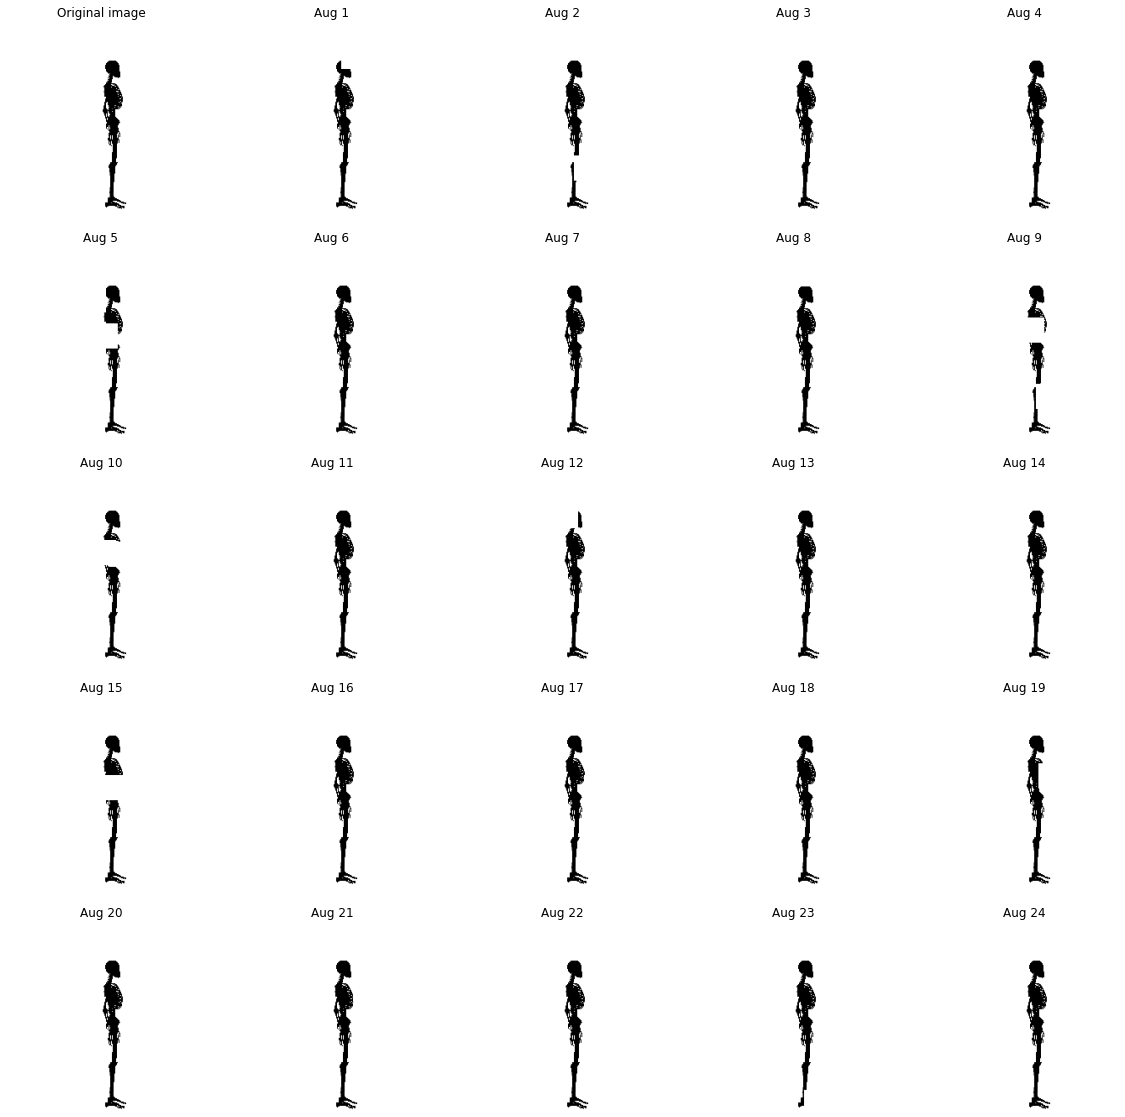

In [12]:
plot_augs('../data/training_masked', tfms, 5, 5, 20, 20)

# AugMix

In [7]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Base augmentations operators."""

import numpy as np
from PIL import Image, ImageOps, ImageEnhance

# ImageNet code should change this value
IMAGE_SIZE = 224


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / 10)


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval.

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / 10.


def sample_level(n):
  return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
  return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
  return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

In [8]:
all_ops = False
mixture_width = 3
aug_prob_coeff = 1.
mixture_depth = -1
aug_severity = 1
def aug(image, preprocess):
    """Perform AugMix augmentations and compute mixture.
    Args:
      image: PIL.Image input image
      preprocess: Preprocessing function which should return a torch tensor.
    Returns:
      mixed: Augmented and mixed image.
    """
    aug_list = augmentations
    if all_ops:
        aug_list = augmentations_all

    ws = np.float32(
        np.random.dirichlet([aug_prob_coeff] * mixture_width))
    m = np.float32(np.random.beta(aug_prob_coeff, aug_prob_coeff))

    mix = torch.zeros_like(preprocess(image))
    for i in range(mixture_width):
        image_aug = image.copy()
        depth = mixture_depth if mixture_depth > 0 else np.random.randint(
            1, 4)
        for _ in range(depth):
            op = np.random.choice(aug_list)
            image_aug = op(image_aug, aug_severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * preprocess(image_aug)

    mixed = (1 - m) * preprocess(image) + m * mix
    return mixed

In [9]:
from glob import glob
import random

from torchvision import transforms

def post_augmix(img):
    '''
        Takes a numpy input and applies the transforms and returns 
        a numpy array
    '''
    preprocess = albumentations.Compose(
        [
            albumentations.RandomBrightnessContrast(p=0.2),
            albumentations.OpticalDistortion(p=0.2),
            albumentations.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.1, rotate_limit=20),
            albumentations.Flip(p=0.5),
        ]
    )
    
    img = preprocess(image=img)['image']
    return img

def plot_augmix(folder, tfms, rows, cols, width, height):
    '''
        Picks a random image from the given folder
        and applies a given albumentations transform
    '''
    folder = glob(os.path.join(folder, '*'))
    img = random.choice(folder)
    
    pil_img = Image.open(img)
    img = np.array(pil_img)

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(width,height))

    for i, ax in enumerate(fig.axes):
        ax.axis("off")
        if i == 0:
            # Original Image
            ax.set_title('Original image')
            ax.imshow(img)
        else:
            img = aug(pil_img, tfms)
            img = np.transpose(img.numpy(), (1,2,0))
            img = post_augmix(img)
            ax.set_title(f'Aug {i}')
            ax.imshow(img)

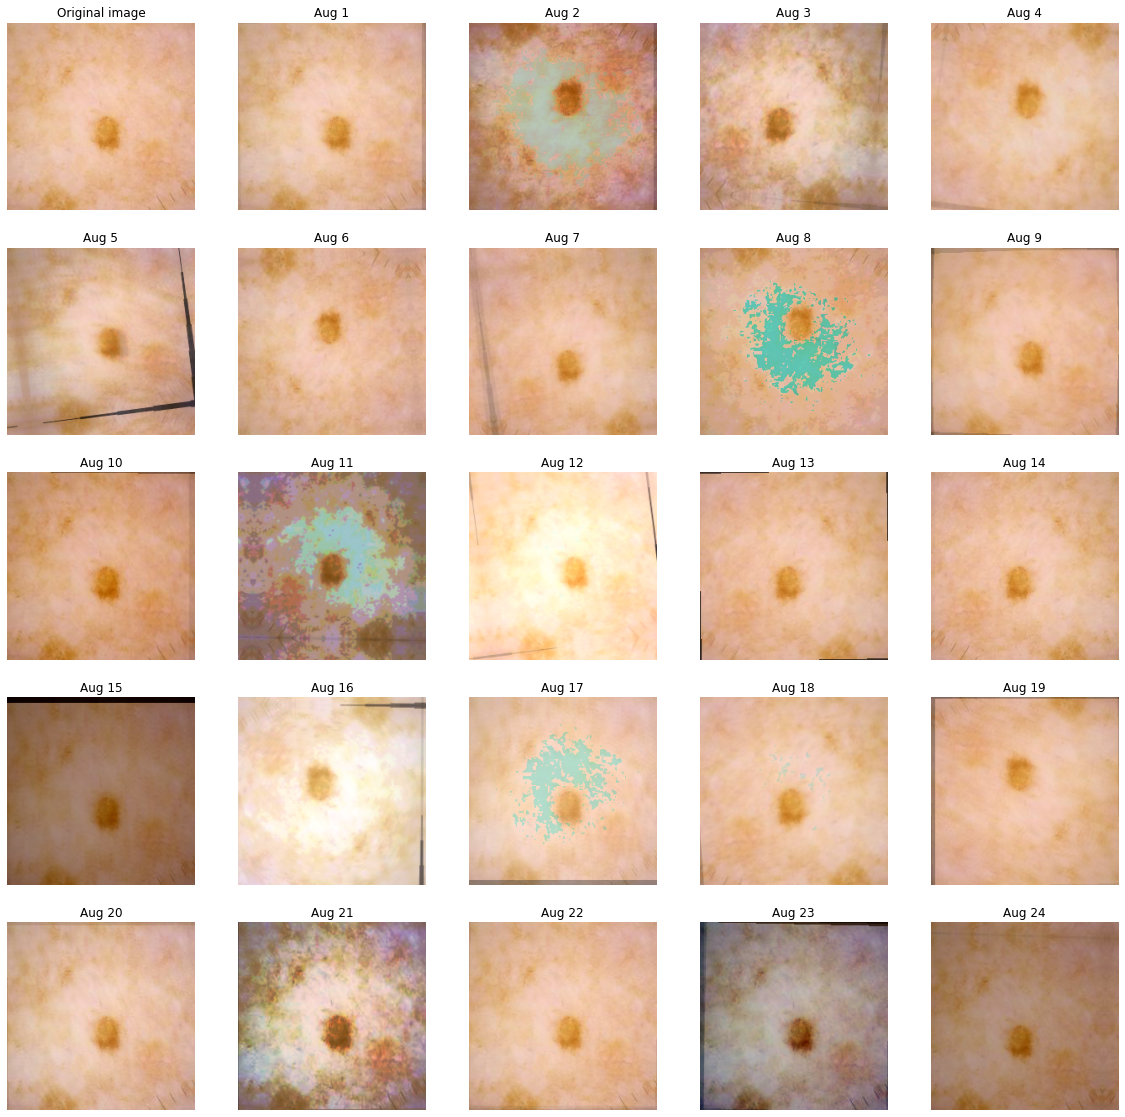

In [12]:
preprocess = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
])
plot_augmix('./data/trainmar224', preprocess, 5, 5, 20, 20)